In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_digits
import random

In [2]:
data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

#data = np.array([[random.gauss(50, 5), random.gauss(50, 10)] for _ in range(200)])
#n_digits = 5

In [3]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score         

In [4]:
import math
from typing import Callable
import copy

def eucledian_dist(point0, point1):
    dist = 0.0
    for i in range(0,len(point0)):
        dist += (point0[i] - point1[i])**2
    return math.sqrt(dist)

class Particle:
    def __init__(self, k: int, points, distance: Callable, objective: Callable, w: float, c1: float, c2:float, bounds):
        self.k = k
        self.points = points
        self.velocity = [[random.uniform(bounds[0], bounds[1]) for _ in range(len(points[0]))] for _ in range(k)]
        self.objective = objective
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.centroids = random.sample(points, k)
        self.distance = distance
        
        self.bestPosition = copy.deepcopy(self.centroids)
        self.currentValue = objective(points, self._assign_clusters(points))
        self.bestValue = self.currentValue
        self.bounds = bounds
        
    def _assign_clusters(self, points):
        clusters = []
        for point in points:
            clusters.append(self.centroids.index(min(self.centroids, key=lambda x: self.distance(point, x))))
        return clusters
    
    def updatePosition(self, globalBestPosition, globalBestValue, globalBestParticle):
        
        for i in range(len(self.centroids)):
            for j in range(len(self.centroids[i])):
                self.centroids[i][j] += self.velocity[i][j]
                
        
        self.currentValue = self.objective(self.points, self._assign_clusters(self.points))
        if self.currentValue < self.bestValue:
            self.bestValue = self.currentValue
            self.bestPosition = copy.deepcopy(self.centroids)
            
            if self.currentValue < globalBestValue:
                globalBestValue = self.currentValue
                globalBestPosition = copy.deepcopy(self.centroids)
                globalBestParticle = copy.deepcopy(self)
                
        return globalBestPosition, globalBestValue, globalBestParticle
            
            
    def updateVelocity(self, globalBestPosition):
        for i in range(len(self.velocity)):
            r1 = random.random()
            r2 = random.random()
            
            for j in range(len(self.velocity[i])):
                cognitive_velocity = r1 * self.c1 * (self.bestPosition[i][j] - self.centroids[i][j])
                social_velocity = r2 * self.c2 * (globalBestPosition[i][j] - self.centroids[i][j])
            
                self.velocity[i][j] = self.w * self.velocity[i][j] + cognitive_velocity + social_velocity  
                if self.velocity[i][j] > self.bounds[1]:
                    self.velocity[i][j] = self.bounds[1]
                elif self.velocity[i][j] < self.bounds[0]:
                    self.velocity[i][j] = self.bounds[0]
        

(1797, 64)
2.3328678221058707
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
2.3363685543871235
2.359731164976854


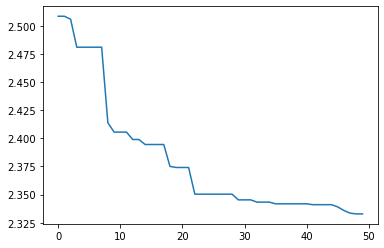

In [5]:
import matplotlib.pyplot as plt
SWARM_SIZE = 10
MAX_ITER = 50
bounds = [-0.5, 0.5]
print(data.shape)
swarm = [Particle(n_digits, data.tolist(), eucledian_dist, davies_bouldin_score, 0.75, 2, 1, bounds) for _ in range(SWARM_SIZE)]

def chs_inverted(points, clusters):
    return -calinski_harabasz_score(points, clusters)

#swarm = [Particle(5, data.tolist(), eucledian_dist, chs_inverted, 0.75, 1, 2, bounds) for _ in range(SWARM_SIZE)]
globalBestPosition = copy.deepcopy(swarm[0].centroids)
globalBestValue = swarm[0].currentValue
globalBestParticle = swarm[0]

for particle in swarm:
    if particle.currentValue < globalBestValue:
        globalBestValue = particle.currentValue
        globalBestPosition = copy.deepcopy(particle.centroids)
        globalBestParticle = particle

bests = []
for i in range(MAX_ITER):
    for j in range(len(swarm)):
        swarm[j].updateVelocity(globalBestPosition)
        globalBestPosition, globalBestValue, globalBestParticle = swarm[j].updatePosition(globalBestPosition, globalBestValue, globalBestParticle)
        
    bests.append(globalBestValue)

#print('Solution: {}, value: {}'.format(globalBestPosition, globalBestValue))
print(globalBestValue)
clusters = globalBestParticle._assign_clusters(data.tolist())
print(set(clusters))
print(davies_bouldin_score(data.tolist(), clusters))
print(davies_bouldin_score(globalBestParticle.points, clusters))

plt.plot(range(MAX_ITER), bests)

In [16]:
from sklearn import metrics
print(metrics.adjusted_mutual_info_score(labels, clusters))
print(metrics.homogeneity_score(labels, clusters))
print(metrics.completeness_score(labels, clusters))
print(metrics.v_measure_score(labels, clusters))


0.49124098127940935
0.4858870031628582
0.5073813005452579
0.4964015838670206


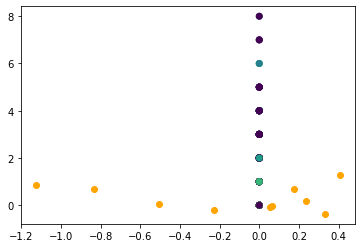

In [7]:
plt.scatter(data[:, 0], data[:, 1], c = clusters)
centroids_np = np.array(globalBestParticle.centroids)
plt.scatter(centroids_np[:, 0], centroids_np[:, 1], color='orange')

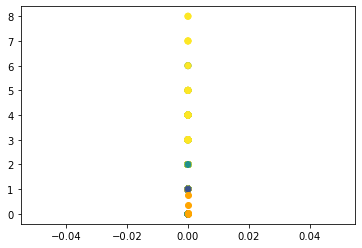

In [8]:
from sklearn.cluster import KMeans

kmean = KMeans(5, init='random').fit(data)
plt.scatter(data[:, 0], data[:, 1], c=kmean.labels_)
plt.scatter(kmean.cluster_centers_[:, 0], kmean.cluster_centers_[:, 1], color='orange')